# Univariate Prophet Forecast for NEDU Profielen

https://facebook.github.io/prophet/docs/quick_start.html#python-api

https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

In [32]:
import pandas as pd
import os
import numpy as np
import pystan
import fbprophet
from fbprophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# fbprophet v0.7.1
# pystan v2.19.1.1
print('fbprophet version ' + fbprophet.__version__)
print('pystan version ' + pystan.__version__)

fbprophet version 0.7.1
pystan version 2.19.1.1


In [3]:
data_processed_location = '../data/processed'

if 'processed' not in os.getcwd():
    os.chdir(data_processed_location)
    
# sample dataset
#df = pd.read_hdf('pc4_verbruiksdata_per_dag_5501.h5').reset_index()
df = pd.read_hdf('nedu_e1a.h5')

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:
#df.rename(columns={"DATUM": "ds", "VERBRUIK": "y"}, inplace=True)

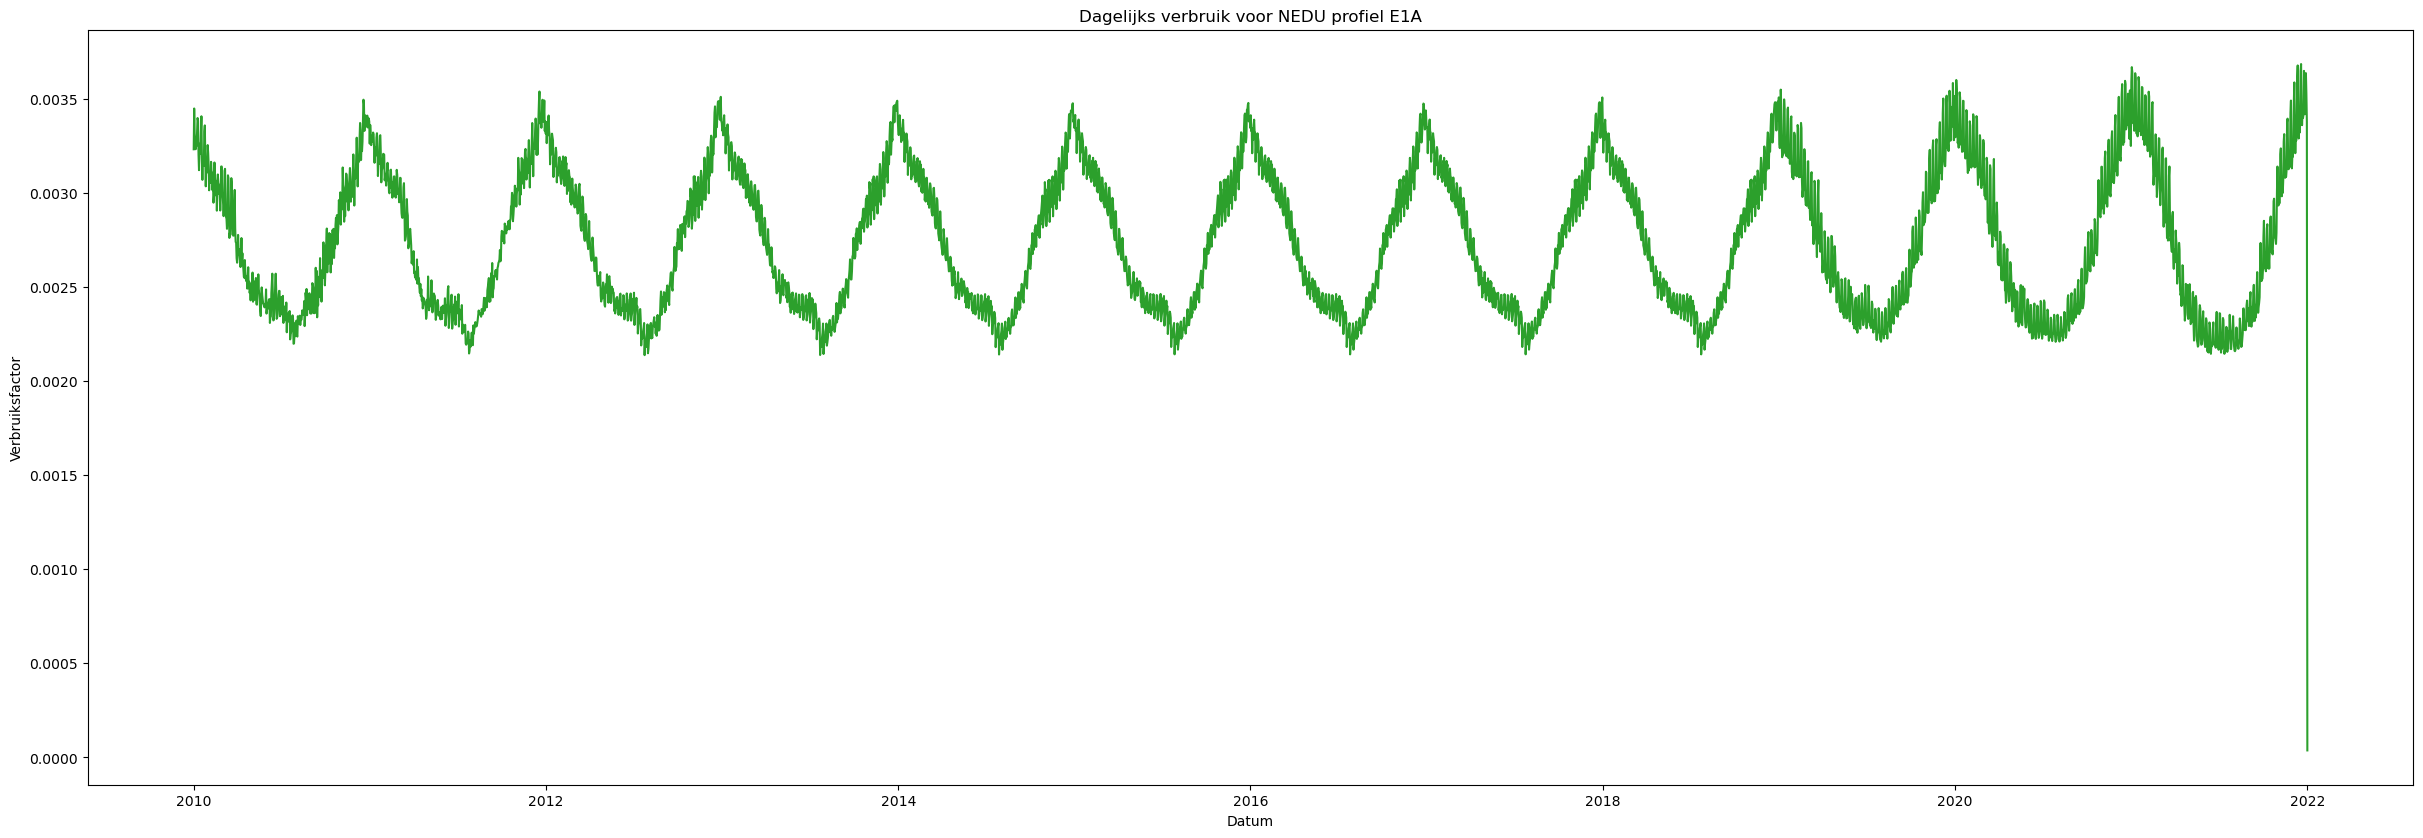

In [5]:
# Time series plot. Visuele check.
plt.figure(figsize=(30,10), dpi=100)
plt.plot(df.ds, df.y, color='tab:green')
plt.gca().set(title=f'Dagelijks verbruik voor NEDU profiel E1A', xlabel='Datum', ylabel='Verbruiksfactor')
plt.show()

In [6]:
# drop the last row
df = df[:-1]

In [7]:
df.tail()

ds         y
4378 2021-12-27  0.003417
4379 2021-12-28  0.003457
4380 2021-12-29  0.003636
4381 2021-12-30  0.003527
4382 2021-12-31  0.003377

In [8]:
# y vermenigvuldigen met 100000
df['y'] = df['y'] * 100000

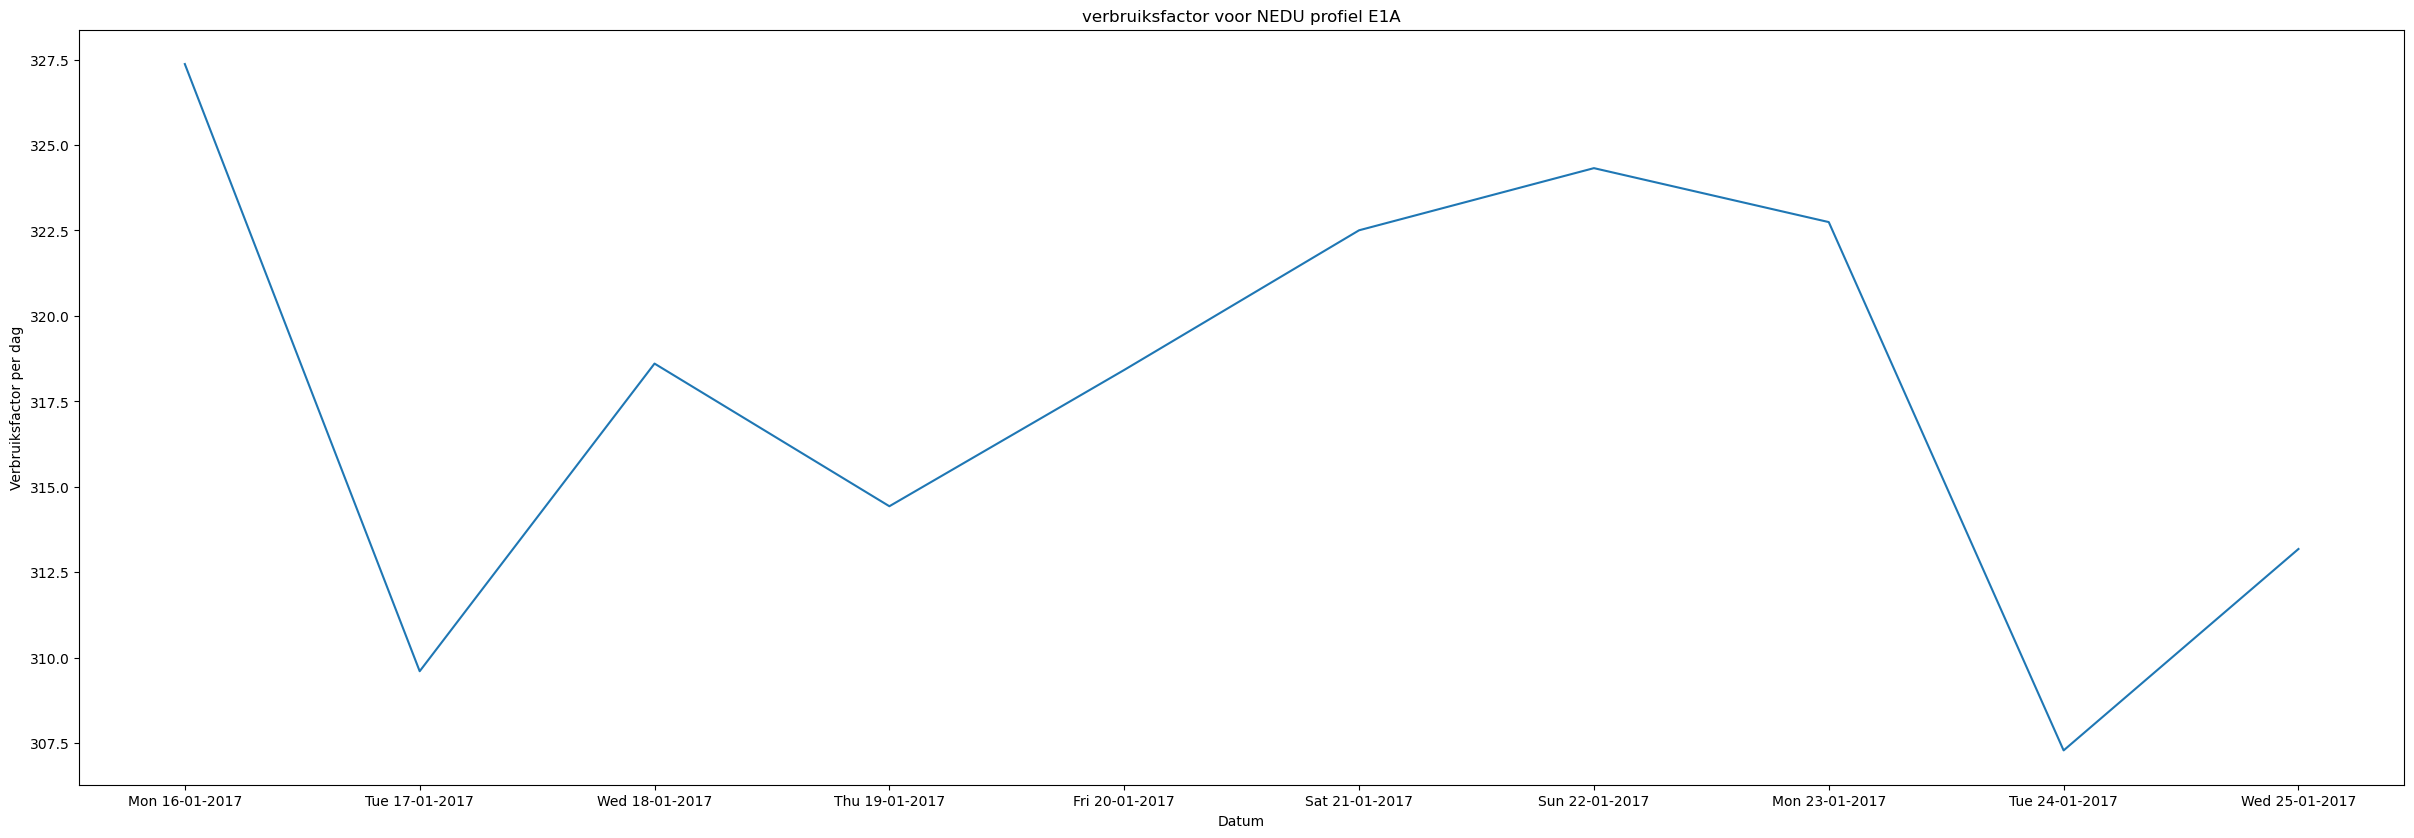

In [9]:
# Time series plot voor een bepaalde tijdsperiode
plt.figure(figsize=(30,10), dpi=100)
plt.plot(df[df['ds'].isin(pd.date_range('2017-01-16 00:00:00', periods=10, freq='D'))].ds
       , df[df['ds'].isin(pd.date_range('2017-01-16 00:00:00', periods=10, freq='D'))].y
       , color='tab:blue')
plt.gca().set(title='verbruiksfactor voor NEDU profiel E1A', xlabel='Datum', ylabel='Verbruiksfactor per dag')
dtFmt = mdates.DateFormatter('%a %d-%m-%Y') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis
plt.show()

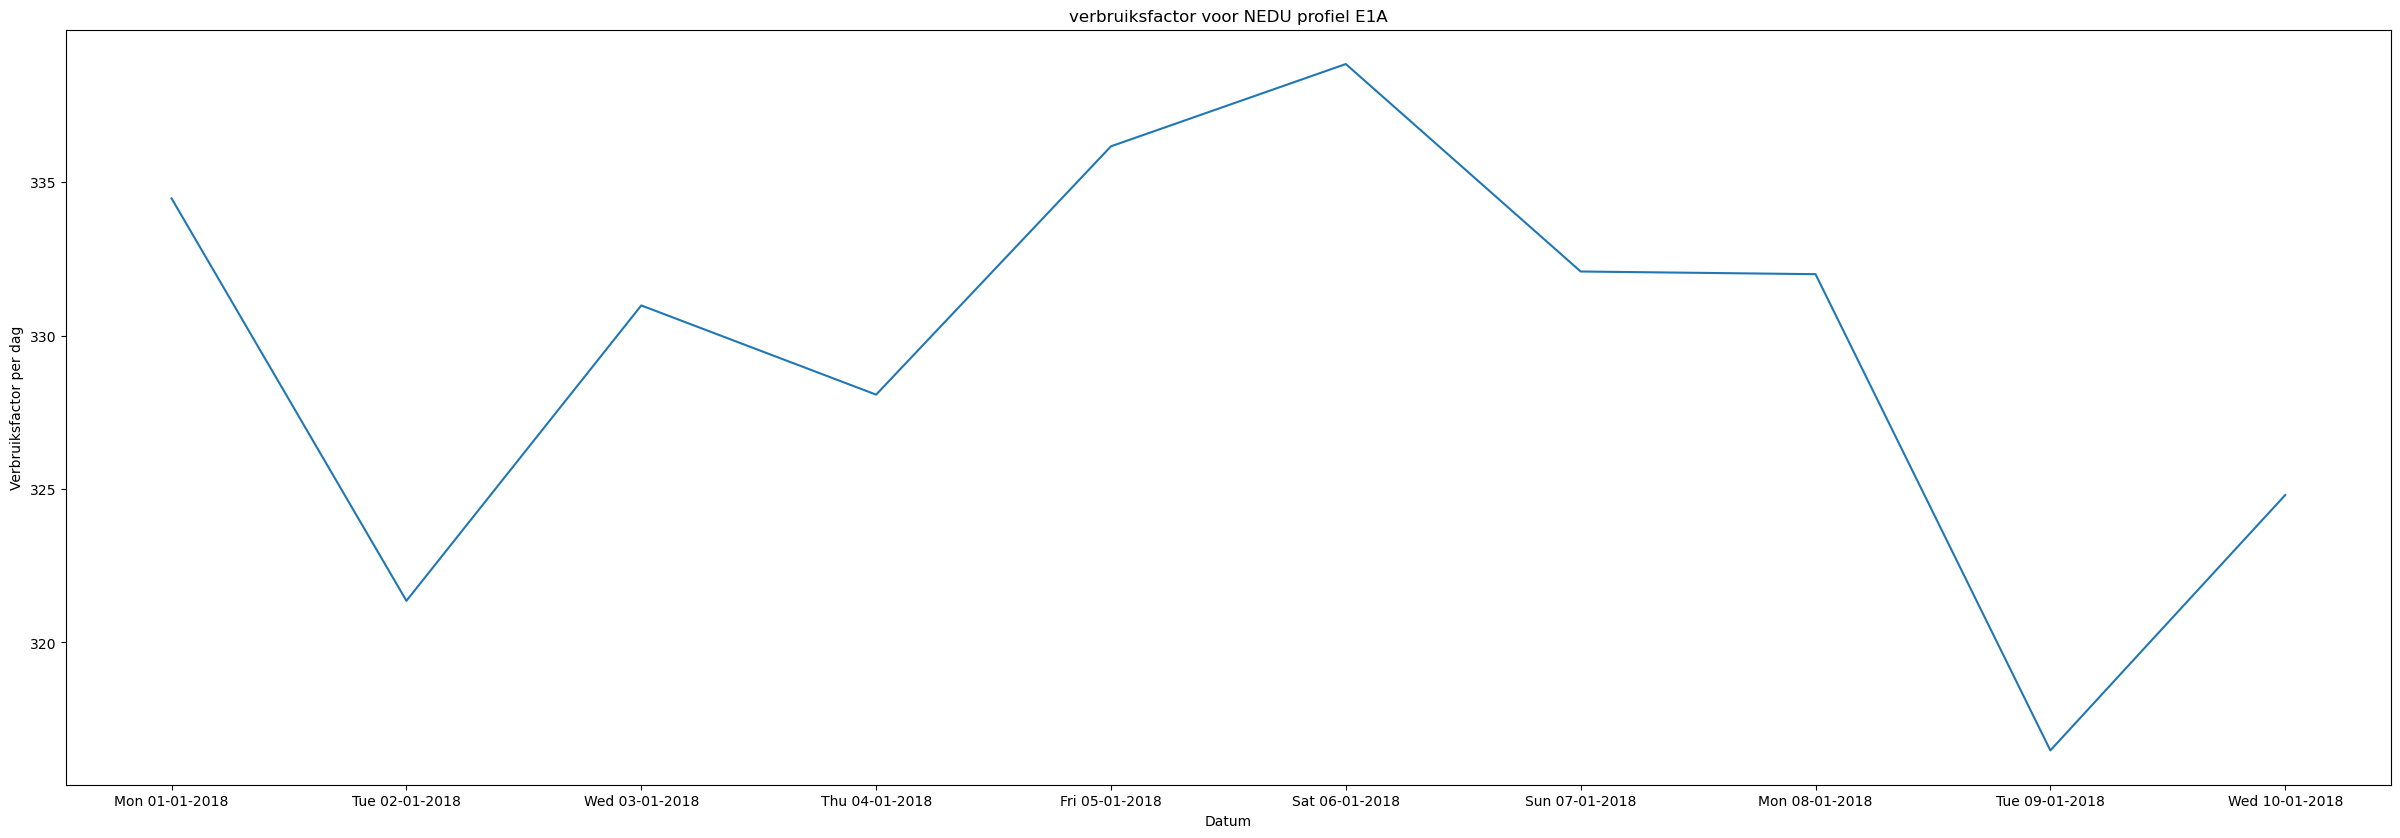

In [10]:
# Time series plot voor een bepaalde tijdsperiode
plt.figure(figsize=(30,10), dpi=100)
plt.plot(df[df['ds'].isin(pd.date_range('2018-01-01 00:00:00', periods=10, freq='D'))].ds
       , df[df['ds'].isin(pd.date_range('2018-01-01 00:00:00', periods=10, freq='D'))].y
       , color='tab:blue')
plt.gca().set(title='verbruiksfactor voor NEDU profiel E1A', xlabel='Datum', ylabel='Verbruiksfactor per dag')

dtFmt = mdates.DateFormatter('%a %d-%m-%Y') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis
plt.show()

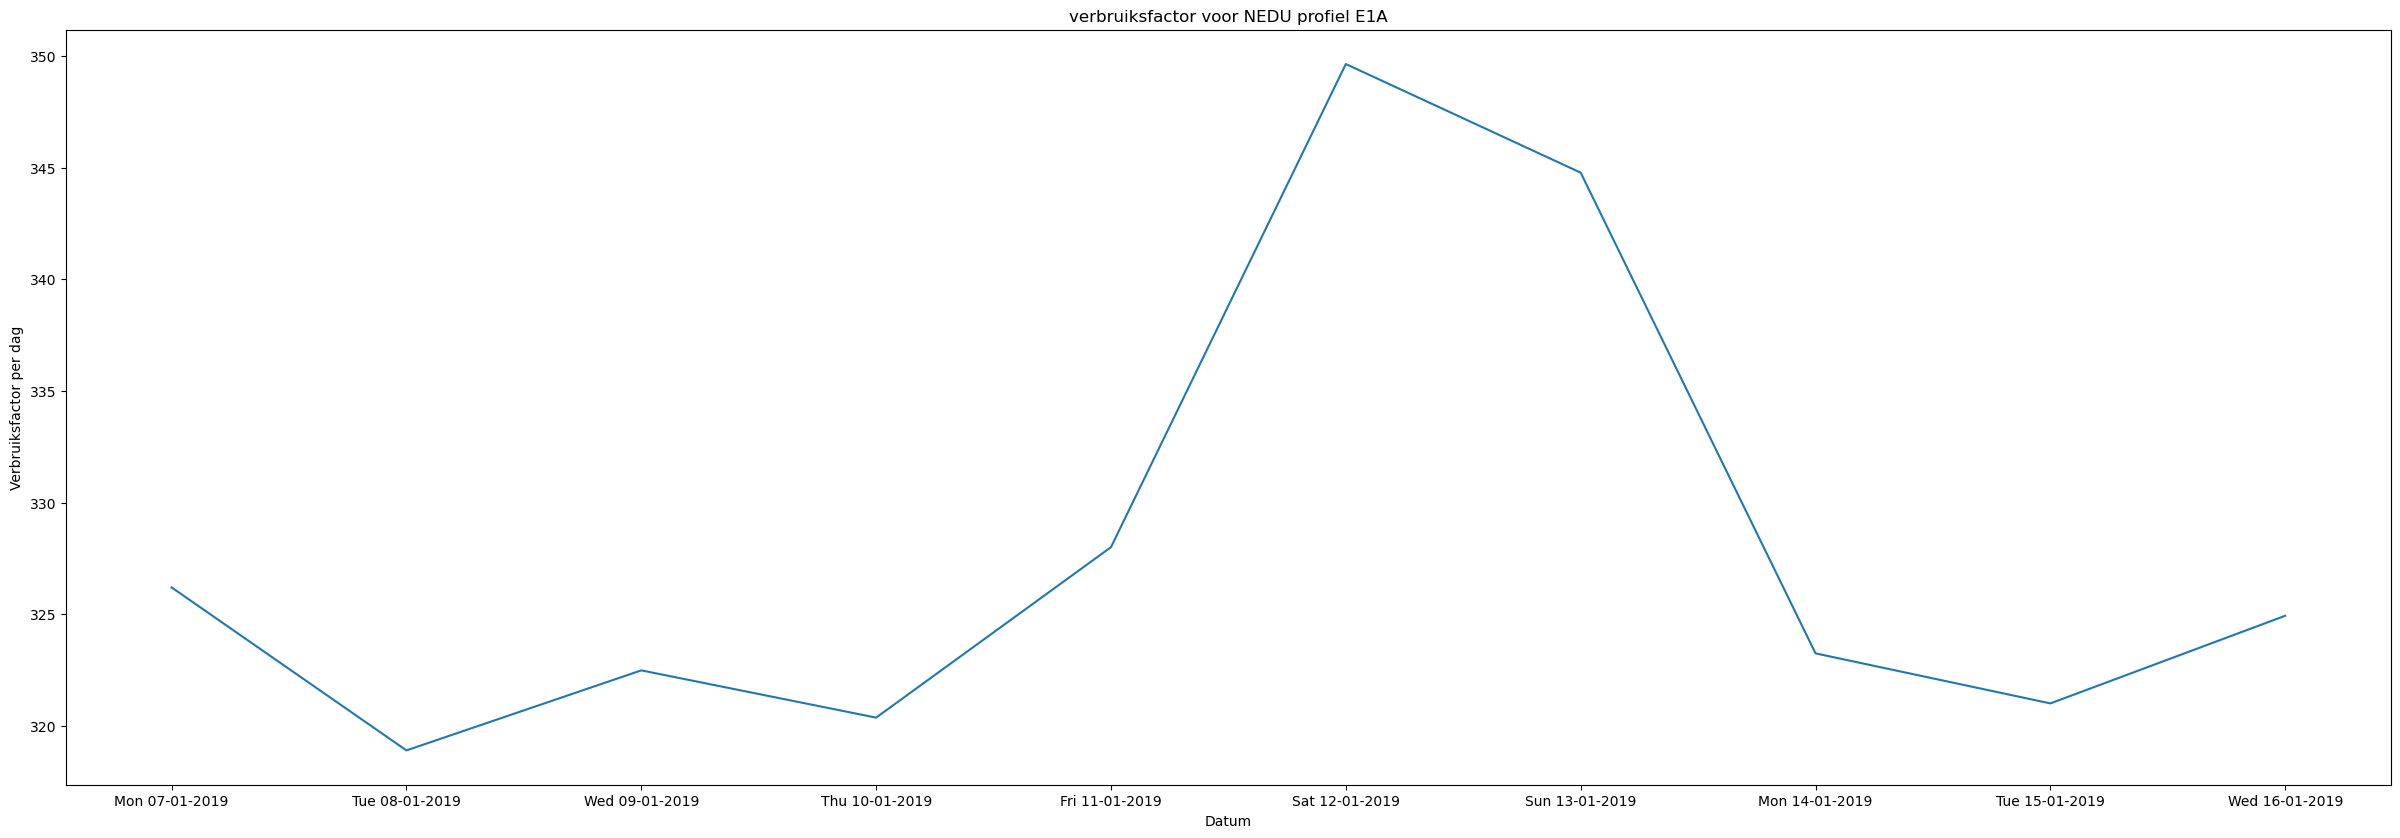

In [11]:
# Time series plot voor een bepaalde tijdsperiode
plt.figure(figsize=(30,10), dpi=100)
plt.plot(df[df['ds'].isin(pd.date_range('2019-01-07 00:00:00', periods=10, freq='D'))].ds
       , df[df['ds'].isin(pd.date_range('2019-01-07 00:00:00', periods=10, freq='D'))].y
       , color='tab:blue')
plt.gca().set(title='verbruiksfactor voor NEDU profiel E1A', xlabel='Datum', ylabel='Verbruiksfactor per dag')

dtFmt = mdates.DateFormatter('%a %d-%m-%Y') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis
plt.show()

In [12]:
df.head()

ds        y
0 2010-01-01  323.121
1 2010-01-02  344.795
2 2010-01-03  331.398
3 2010-01-04  327.535
4 2010-01-05  323.160

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4383 entries, 0 to 4382
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4383 non-null   datetime64[ns]
 1   y       4383 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 102.7 KB


### Train en Test dataset

In [14]:
split_date = '01-Jan-2019'
df_train = df.loc[df.ds <= split_date].copy()
df_test = df.loc[df.ds > split_date].copy()
print (f'Length full     dataset: {len(df)} samples')
print (f'Length training dataset: {len(df_train)} samples')
print (f'Length test     dataset: {len(df_test)} samples')

Length full     dataset: 4383 samples
Length training dataset: 3288 samples
Length test     dataset: 1095 samples


In [15]:
print(df_train.tail())

             ds        y
3283 2018-12-28  343.732
3284 2018-12-29  347.683
3285 2018-12-30  348.478
3286 2018-12-31  338.254
3287 2019-01-01  350.700


### Train model

In [33]:
holidays = pd.DataFrame({'holiday': 'nieuwjaarsdag',
                         'ds': pd.to_datetime(['2010-01-01']),
                         'lower_window': 0,
                         'upper_window': 1,
})

In [17]:
# We fit the model by instantiating a new Prophet object.
# Any settings to the forecasting procedure are passed into the constructor. 
# Then you call its fit method and pass in the historical dataframe. Fitting should take 1-5 seconds.
m = Prophet(growth='linear',
    changepoints=None,
    n_changepoints=2, #25,
    changepoint_range=0.4, #0.8,
    yearly_seasonality=True, #'auto',
    weekly_seasonality=True, #'auto',
    daily_seasonality=False, #'auto',
    holidays= holidays, #None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None)
m.add_country_holidays(country_name='NL')  # holidays van Nederland toevoegen
m.fit(df_train)

In [18]:
# Python
m.train_holiday_names

0          nieuwjaarsdag
1          Nieuwjaarsdag
2         Eerste paasdag
3          Goede Vrijdag
4         Tweede paasdag
5             Hemelvaart
6     Eerste Pinksterdag
7     Tweede Pinksterdag
8        Eerste Kerstdag
9        Tweede Kerstdag
10            Koningsdag
11        Bevrijdingsdag
12         Koninginnedag
dtype: object

### Predictions voor de test data

In [19]:
future = pd.DataFrame(df_test['ds'])

In [20]:
future.tail()

ds
4378 2021-12-27
4379 2021-12-28
4380 2021-12-29
4381 2021-12-30
4382 2021-12-31

In [21]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
1090 2021-12-27  344.056473  337.847505  349.652912
1091 2021-12-28  332.261744  326.632095  337.707745
1092 2021-12-29  335.178232  329.834470  340.540113
1093 2021-12-30  333.539889  327.835626  339.390996
1094 2021-12-31  336.837107  331.372684  342.252240

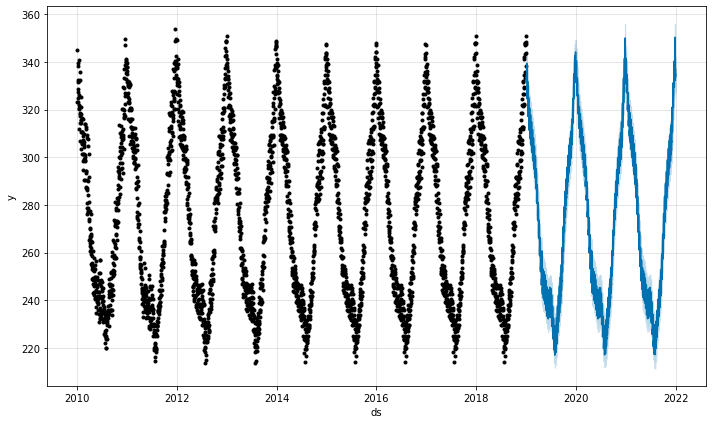

In [22]:
# You can plot the forecast by calling the Prophet.plot method and passing in your forecast dataframe.
fig1 = m.plot(forecast)

In [23]:
# forecast en actual combineren
df_test_all = pd.merge(df_test, forecast, on='ds', how='left')
df_test_all[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds        y        yhat  yhat_lower  yhat_upper
0 2019-01-02  325.682  333.486228  328.252154  338.576523
1 2019-01-03  323.759  331.413723  326.149467  336.799782
2 2019-01-04  326.290  334.314484  328.481165  339.831474
3 2019-01-05  354.826  339.429905  334.095940  344.833139
4 2019-01-06  346.088  338.803868  333.132304  344.375328

<AxesSubplot:xlabel='ds'>

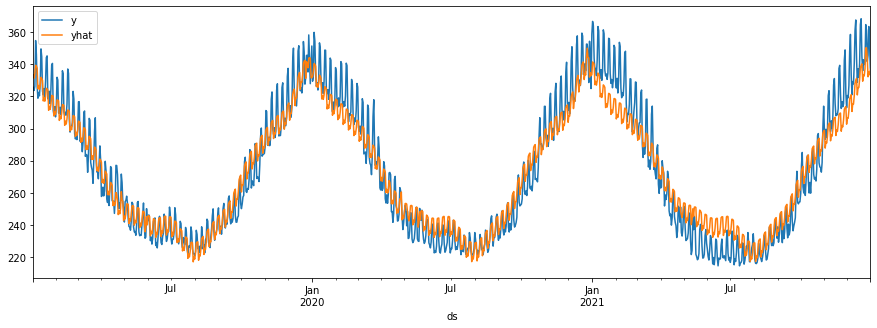

In [24]:
df_test_all.plot(x='ds', y=['y','yhat'], figsize=(15,5))

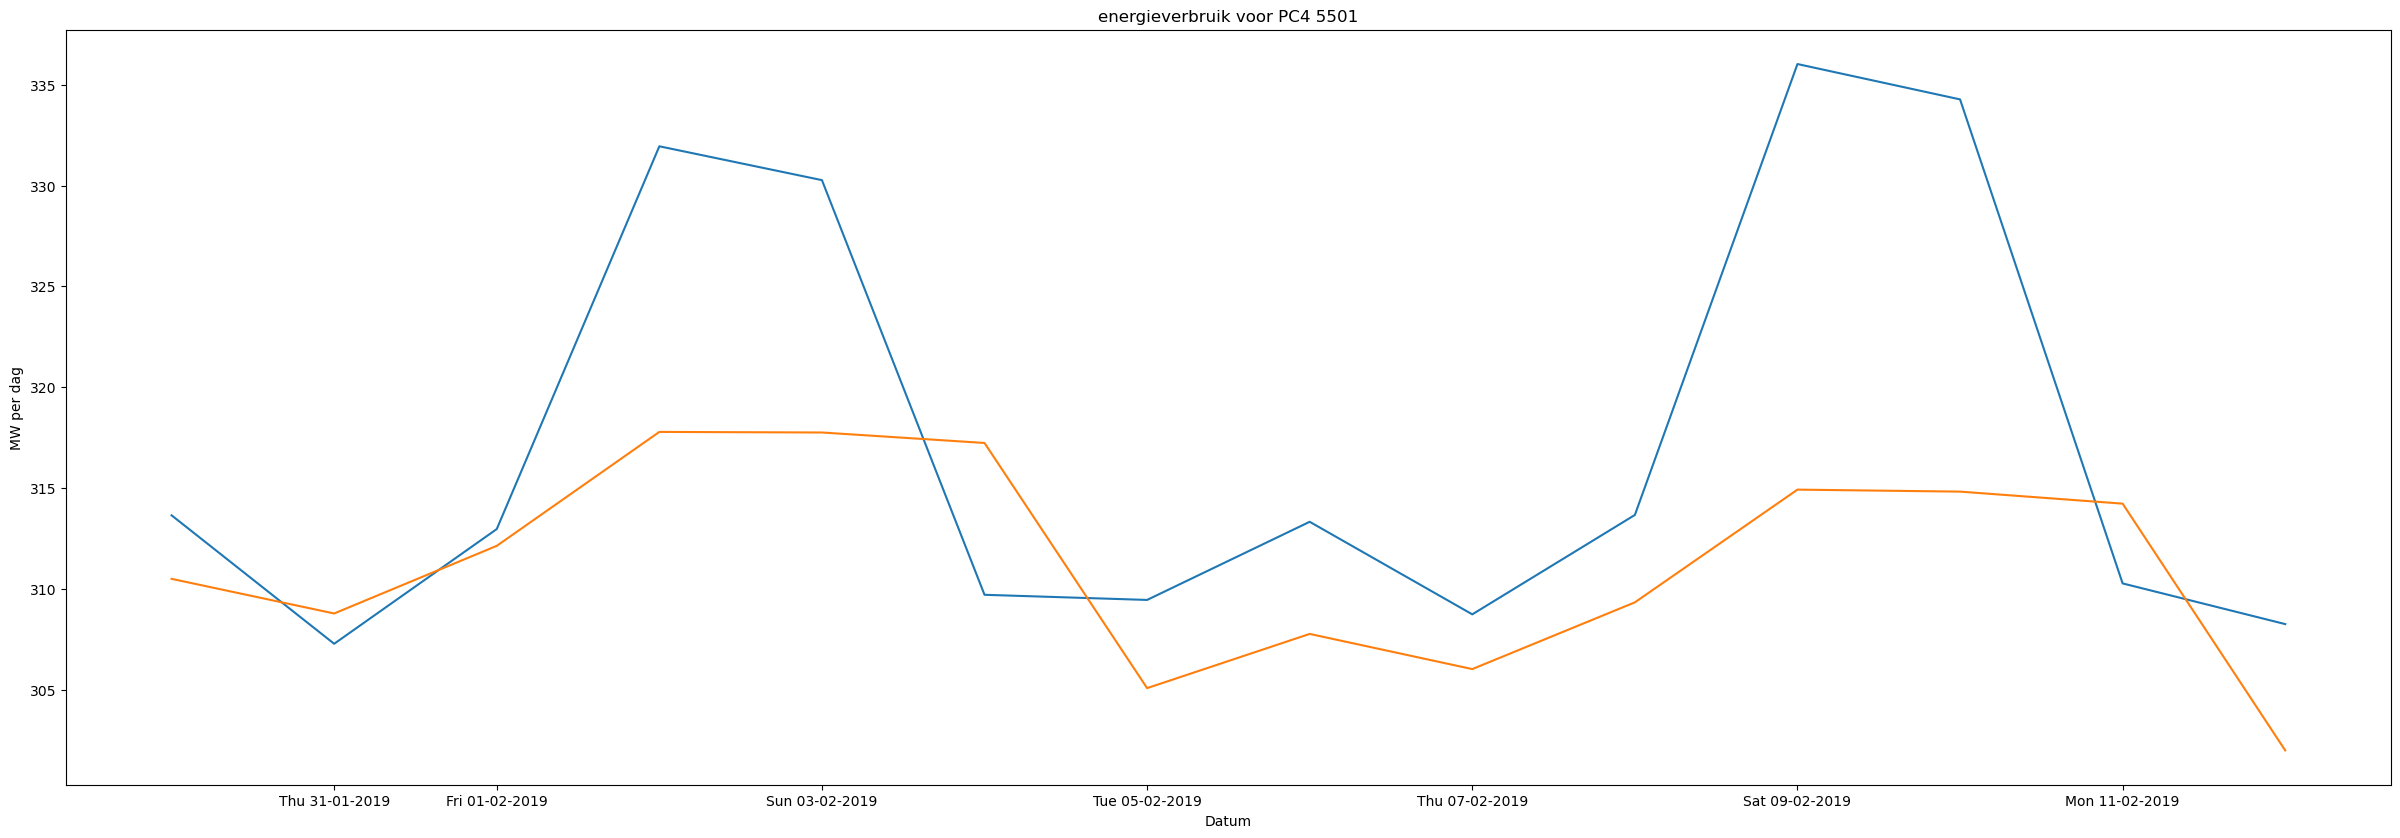

In [25]:
# Time series plot voor een bepaalde tijdsperiode
plt.figure(figsize=(30,10), dpi=100)
plt.plot(df_test_all[df_test_all['ds'].isin(pd.date_range('2019-01-30 00:00:00', periods=14, freq='D'))][['ds']]
       , df_test_all[df_test_all['ds'].isin(pd.date_range('2019-01-30 00:00:00', periods=14, freq='D'))][['y','yhat']]
       )
plt.gca().set(title='energieverbruik voor PC4 5501', xlabel='Datum', ylabel='MW per dag')
dtFmt = mdates.DateFormatter('%a %d-%m-%Y') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis
plt.show()

In [26]:
df_all = pd.concat([df_train, df_test_all], sort = False)

<AxesSubplot:xlabel='ds'>

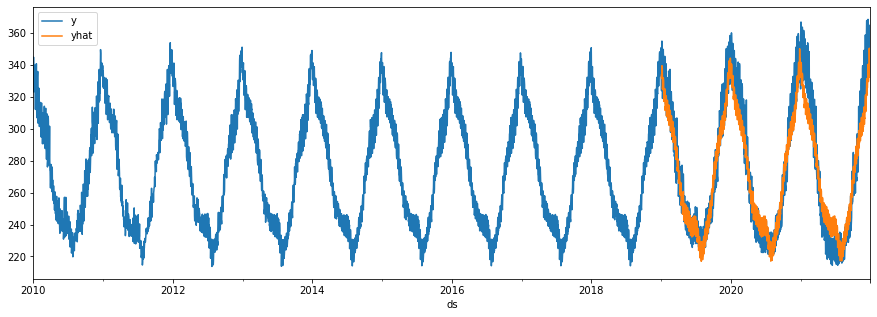

In [27]:
df_all.plot(x='ds', y=['y','yhat'], legend=True, figsize=(15,5))

### Evaluate the Performance

In [36]:
# The MAPE (Mean Absolute Percent Error) measures the size of the error
# in percentage terms.
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [37]:
y_test = df_test_all['y']
y_test_pred = df_test_all['yhat']

In [38]:
print('R^2   test: %.2f' % (r2_score(y_test, y_test_pred)))

print('MSE   test: %.2f' % (mean_squared_error(y_test, y_test_pred)))

print('RMSE  test: %.2f' % (np.sqrt(mean_squared_error(y_test, y_test_pred))))

print('MAE   test: %.2f' % (mean_absolute_error(y_test, y_test_pred)))

print('MAPE  test: %.2f' % (mean_absolute_percentage_error(y_test, y_test_pred)))

print(f'\nMean absolute percent accuracy: {100 - mean_absolute_percentage_error(y_test, y_test_pred):.2f}%')

R^2   test: 0.93
MSE   test: 128.14
RMSE  test: 11.32
MAE   test: 8.72
MAPE  test: 3.15

Mean absolute percent accuracy: 96.85%


### Plots

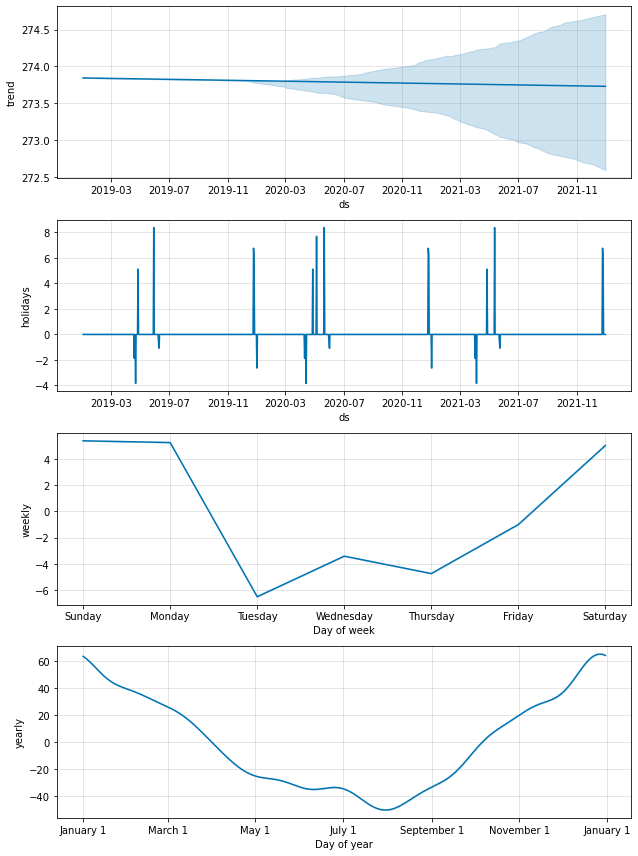

In [39]:
# If you want to see the forecast components, you can use the Prophet.plot_components method. 
# By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. 
# If you include holidays, you’ll see those here, too.
fig2 = m.plot_components(forecast)


In [40]:
# An interactive figure of the forecast and components can be created with plotly. 
# You will need to install plotly 4.0 or above separately, as it will not by default be installed with prophet. 
# You will also need to install the notebook and ipywidgets packages.
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [41]:
plot_components_plotly(m, forecast)

### Trainen met de volledige dataset t/m 2020

In [ ]:
end_date = '31-Dec-2020'
df_train_full = df.loc[df['ds'] <= end_date].copy()

In [ ]:
df_train_full.tail()

In [ ]:
m_full = Prophet(growth='linear',
    changepoints=None,
    n_changepoints=2, #25,
    changepoint_range=0.4, #0.8,
    yearly_seasonality=True, #'auto',
    weekly_seasonality=True, #'auto',
    daily_seasonality=False, #'auto',
    holidays= holidays, #None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None)
m_full.add_country_holidays(country_name='NL')  # holidays van Nederland toevoegen
m_full.fit(df_train_full)

In [ ]:
fig2 = m_full.plot_components(forecast)

### Predictions voor 2021 en 2022

In [ ]:
df_2021_2022 = pd.DataFrame(pd.date_range(start='1/1/2021', end='31/12/2022' , freq='D')
                            , columns=['ds']).sort_values(by='ds', ascending=True)

In [ ]:
df_2021_2022.tail()

In [ ]:
forecast_2021_2022 = m_full.predict(df_2021_2022)
forecast_2021_2022[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig1 = m_full.plot(forecast_2021_2022)

In [ ]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m_full, forecast_2021_2022)

In [ ]:
plot_components_plotly(m_full, forecast_2021_2022)